<a href="https://colab.research.google.com/github/RVT123123/audio_classification/blob/master/audio_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=bfc6f2b2d0344205e04fa5055d1d5010c836978093940b9b978f8addccd3258f
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config

In [0]:
def check_data():
    if os.path.isfile(config.p_path):
        print("Loading existing data for  {} model".format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/audio_classification/Audio-Classification-master/instruments.csv')

In [0]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0],tmp.data[1]
    
    X = []
    y = []
    _min,_max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('/content/gdrive/My Drive/audio_classification/Audio-Classification-master/clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate,numcep = config.nfeat , nfilt=config.nfilt, nfft=config.nfft )
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min = _min
    config.max = _max
    X, y = np.array(X), np.array(y)
    X = (X - _min)/ (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0] , X.shape[1] , X.shape[2] , 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0] , X.shape[1] , X.shape[2])
    y = to_categorical(y, num_classes=10)
    config.data = (X,y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config,handle,protocol =2)
    
    return X,y

In [0]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1,1),
                     padding= 'same' , input_shape = input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1),
                     padding= 'same'))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1),
                     padding= 'same'))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1),
                     padding= 'same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model


In [0]:
def get_recurrent_model():
    #shape of data for RNN is(n,time,feat)
    model = Sequential()
    model.add(LSTM(128, retun_sequence=True,input_shape=input_shape))
    model.add(LSTM(128, retun_sequence=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model
        


In [0]:
df.set_index('fname', inplace=True)

In [0]:
for f in df.index:
    rate, signal = wavfile.read('/content/gdrive/My Drive/audio_classification/Audio-Classification-master/clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

In [0]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

In [0]:
n_samples = 2 * int(df['length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p =prob_dist)


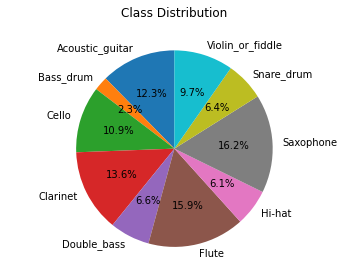

In [60]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [0]:
######## set mode for our model ##############
##########  conv for convolution
##########  time for lstm stack 


config = Config(mode='conv')


In [62]:
if config.mode == 'conv':
    X ,y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1] , X.shape[2] ,1)
    model =  get_conv_model()
    
elif config.mode == 'time':
    X , y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1] , X.shape[2] )
    model =  get_recurrent_model()

Loading existing data for  conv model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_4 (Flatt

In [0]:
class_weight = compute_class_weight('balanced',
                                    np.unique(y_flat),
                                    y_flat)

In [66]:
checkpoint = ModelCheckpoint(config.model_path,monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False,period=1)
model.fit(X, y, epochs=10, batch_size=32,
          shuffle=True,validation_split=0.1,
          callbacks=[checkpoint],
          class_weight = class_weight)

model.save(config.model_path)

Train on 22602 samples, validate on 2512 samples
Epoch 1/10
22602/22602 [==============================] - 56s 2ms/step - loss: 1.0064 - acc: 0.6417 - val_loss: 0.5259 - val_acc: 0.8089

Epoch 00001: val_acc improved from -inf to 0.80892, saving model to /content/gdrive/My Drive/AUDIO_classifier/models/conv.model
Epoch 2/10
22602/22602 [==============================] - 55s 2ms/step - loss: 0.4583 - acc: 0.8412 - val_loss: 0.3423 - val_acc: 0.8826

Epoch 00002: val_acc improved from 0.80892 to 0.88256, saving model to /content/gdrive/My Drive/AUDIO_classifier/models/conv.model
Epoch 3/10
22602/22602 [==============================] - 56s 2ms/step - loss: 0.3338 - acc: 0.8843 - val_loss: 0.2827 - val_acc: 0.9072

Epoch 00003: val_acc improved from 0.88256 to 0.90725, saving model to /content/gdrive/My Drive/AUDIO_classifier/models/conv.model
Epoch 4/10
22602/22602 [==============================] - 56s 2ms/step - loss: 0.2579 - acc: 0.9097 - val_loss: 0.2464 - val_acc: 0.9172

Epoch 000